## Quantum Circuit Born Machines

This notebook will walk you through the basics of setting up a Quantum Circuit Born Machine (QCBM) to represent and lear the probability distribution of a classical dataset as quantum pure states.

The Notebook uses Xanadu's [PennyLane](https://pennylane.ai) library for differentiable programming of quantum computers. If you are not familiar with PennyLane, check out their [demos](https://pennylane.ai/qml/demonstrations.html) to get started. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pennylane import numpy as np
import scipy
from pennylane.templates import BasicEntanglerLayers,StronglyEntanglingLayers,RandomLayers

/usr/local/Cellar/python@3.9/3.9.10/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [2]:
import pennylane as qml
qml.__version__

'0.20.0'

### Set up your target distribution here

As a toy example, let's try and learn a Gaussian distribution over n_{qubits}^{2} basis states.

In [3]:
n_qubits = 4
bin_state_rep = [np.binary_repr(x,n_qubits) \
                      for x in range(2**n_qubits)]
n_basis = 2**n_qubits
P_target=np.zeros(n_basis)

# Generate a Gaussian distribution centered at n_basis/2
mean, standard_deviation = n_basis/2,2.5
x_values = np.arange(0,n_basis-1,1)
y_values = scipy.stats.norm(mean,standard_deviation)
for q in range(0,2**n_qubits-1):
    P_target[q] = y_values.pdf(x_values[q]) 

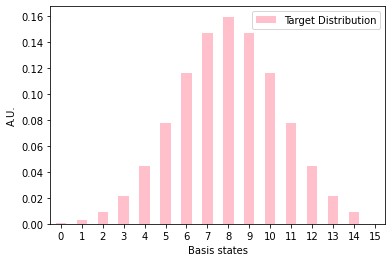

In [4]:
data_df = pd.DataFrame(P_target)
data_df.columns=['Target Distribution']
ax = data_df.plot(kind='bar',color='pink',rot=0)
ax.set(xlabel="Basis states", ylabel="A.U.")

plt.show()

### Parameterized Quantum Circuit

A *parameterized quantum circuit* consists of layers or blocks of rotational and entangling gates that can be repeated to maximize the circuit's expressibility.

We use the `BasicEntanglingLayers` **template** available from `PennyLane`. But there are many other templates available, and it will depend on your application, and what kind of hardware you want to deploy it on, because of connectivity limitations, the more CNOTs you have on your circuit, the harder it is to find a device to run it.

In [5]:
n_layers = 6

# We initialize the circuit parameters randomly. For BasicEntanglingLayers, we 
# only have one layer of rotational parameters, followed by CNOTs
init_params = (2.*np.pi)*np.random.random(n_layers*n_qubits)
# We have to do this because PennyLane likes to have a list of wires or qubits.
dev_wires = [np.array(idx, requires_grad=True) for idx in range(n_qubits)]

# Select backend, qubit is the default simulator backend for PennyLane, but you can also use 'mixed'
# to simulate noise, or other hardware backends.
dev = qml.device('default.qubit', wires=dev_wires)

In [6]:
# The template is used inside a qnode, which is required by Pennylane as a way to keep a box of quantum things and another one for classical things.
@qml.qnode(dev)
def circuit(init_params):
    # We get the "shape" of the circuit or template, to figure out how to arrange the parameters
    # we need to initialize
    shape = BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_qubits)
    params=np.asarray(init_params).reshape(shape)
    #dev_wires = [np.array(idx, requires_grad=True) for idx in range(n_qubits)]

    # Build your template.
    BasicEntanglerLayers(params,wires=dev_wires)
    return qml.probs(wires=dev_wires)

<AxesSubplot:>

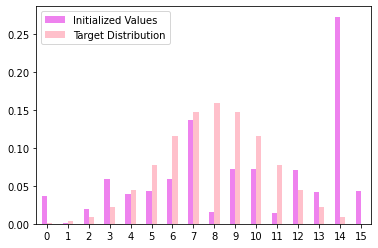

In [21]:
data_df = pd.DataFrame(circuit(init_params))
data_df.columns=['Initialized Values']
data_df['Target Distribution'] = pd.DataFrame(P_target)
data_df.plot(kind='bar',color={"pink", "violet"},rot=0)

We can now define a loss function between two probability distributions. Again, you can code more fancy functions, depending on your application.

In [22]:
def cosine_distance(p,q):
    #p = target
    pnorm = np.sqrt(np.sum([x**2 for x in p]))

    #q = pdf(params)
    qnorm = np.sqrt(np.sum([x**2 for x in q]))
    return 1.0 - (p@q)/(pnorm*qnorm)


Use a gradient-based classical optimizer to train the circuit and update parameters.

In [23]:
nsteps=100 # number of training steps to execute 

# There are several optimizers available in PennyLane, but this is the one
# we found to give better performance
opt_method = qml.AdamOptimizer
opt = opt_method(stepsize=0.1) 

In [25]:
# Make a copy of the initial parameters, since the 'params' variable will be updated during training.
params = init_params.copy()

for i in range(nsteps):
    # update the circuit parameters in each iteration
    params = opt.step(lambda v: cosine_distance(P_target,circuit(v)), params)

<AxesSubplot:>

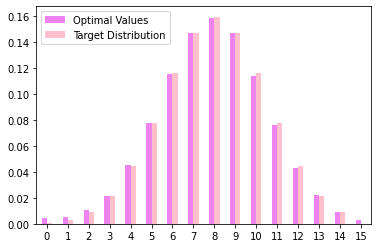

In [28]:
data_df = pd.DataFrame(circuit(params))
data_df.columns=['Optimal Values']
data_df['Target Distribution'] = pd.DataFrame(P_target)
data_df.plot(kind='bar',color={"pink", "violet"},rot=0)